In [68]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import math
from math import exp
from numpy.polynomial.polynomial import polyval
import scipy.integrate as intg
import scipy.interpolate as inp
from scipy.misc import derivative

from CoolProp.CoolProp import PropsSI

# Funtion

functions for MgCl2(aq) thermodynamic state (for implementation in Modelica)

## 1. soluability.

$para_{sol} = [5.543, 1.834*10^{-2}, -6.093*10^{-4}, 1.858*10^{-5}, -2.124*10^{-7}, 8.969*10^{-10}]$

$T = [1, T, T^{2}, T^{3}, T^{4}, T^{5}]$

$x = para_{sol} * T$

## 2. density.
already implemented (density of water using IF97 of MODELICA)\
$\rho = \rho_w * \rho_{rel}$

## 3. Vapor pressure
already implemented (vapor pressure of water using IF97 of MODELICA)\
$p_{sat} = \alpha * p_{sat,w}$

## 4. Viscosity
current model not completed, but it is firstly not important. will be completed if needed

## 5. heat capacity
already implemented, but need to be validated.\

update: validated, function ok, disagreement because of state function for water \
$c_{p} = c_{p,w} * c_{p,rel}$ 

## 6. Enthalpy

Theory: reference enthalpy @ 25°C + integration of heat capacity cp with respect to T

Implementation: multivariante non-linear-regression for modelica.

parameter:
[-1.05252616e+03,  3.75550823e+00, -4.59419938e+02, 4.78672511e-04, -4.44122366e+00,  8.36881428e+02]

$h_{solution} = -1052.5261563 + 3.75550823*T + -4.59419938*10^{2}*x + 4.78672511*10^{-4}* T^2 + T*x*-4.44122366 + x^2*8.36881428*10^2 $


# general functions

In [2]:
def molal_to_massfr(m):
    M_mgcl2 = 95.211    
    x = m*M_mgcl2/1000 / (m*M_mgcl2/1000 + 1 )
    return x

In [3]:
def massfr_to_molal(x):
    M_mgcl2 = 95.211
    m = x/(95.211/1000) / (1-x)
    return m

In [4]:
# relative mean square root error
def RMSRE(ref, sim):
    ref, sim = np.array(ref), np.array(sim)
    result = np.sqrt((((ref - sim)/ref) ** 2).mean())
    return result

# MgCl2 Function

## heat capacity of MgCl2 solution 

In [18]:
# model for calculation heat capacity of water
para_wa = [88.7891, -120.1958, -16.9264, 52.4654, 0.10826, 0.46988]
cp_w = lambda theta: para_wa[0] + para_wa[1]*theta**0.02 + para_wa[2]*theta**0.04 + para_wa[3]*theta**0.06 + para_wa[4]*theta**1.8 + para_wa[5]*theta**8
cp_w_prop = lambda T: PropsSI('C', 'T', T, 'Q',0, 'IF97::Water')
# cp_w_prop performed not as well as the water equation given by Conde in his paper,
# because his model were developed by the water capacity calculated using his equation

In [19]:
# correlation factor
cp_rel = lambda T,x: math.exp(1.148*x)+(-7.316-0.005528*T+T**0.3264)*x

In [20]:
# calculation of heat capacity of MgCl2-Solution
cp_MgCl2_aq = lambda T,x: cp_rel(T, x) * cp_w(theta=T/228-1)

In [21]:
cp_MgCl2_aq(293.15, 0.3)

2.678810186657258

In [22]:
molal_to_massfr(4)

0.2758052321623587

## Enthalpy of MgCl2-Solution

### Step 1: calculate "relative" enthalpy of aqueous solution

In [42]:
# need to compute fisrtly the relative apparent molal entahlpy
para_ramh_used = [8.3642, -6.8325, 4.2148, -0.56344]
ramh = lambda m: para_ramh_used[0]*m**0.5 + para_ramh_used[1]*m**1 + para_ramh_used[2]*m**1.5 + para_ramh_used[3]*m**2

rel_h = lambda m: ramh(m)*m # relative enthalpy of aqueous MgCl2 (unit kJ/kg_water)

### Step2: compute reference enthalpy of MgCl2-Soluation at 25 °C

In [43]:
delta_solution_unlimited = -150.82
# refer to Jahn and Wolf 1993
# NBS 159.83
# Shin and Criss 155.82

h_water = lambda T: PropsSI('H','T',T,'Q',0, 'IF97::Water')/1000 #kJ/kg
h_0_ref_25 = lambda m: delta_solution_unlimited * m + h_water(298.15) # kJ/kg_h2o ... input mol/kg
h_at_25_mol = lambda m: (h_0_ref_25(m) + rel_h(m))/(1+0.095211*m) # unit kJ/kg # # kJ/kg_mgcl2_aq ... input mol/kg
h_at_25_mass_frac = lambda x: h_at_25_mol(massfr_to_molal(x)) # unit kJ/kg

### Step 3: calculate "Absolute" Enthalpy of MgCl2

#### physical calculation

In [49]:
# simplified calculation of enthalpy difference between two solution with same concentration but different temperature: integration of Cp(T)dT
# function to get h_difference from T and x (enthalpy of dilution excluded...)
def get_intg_cp_dT(xi, T_1, T_2):
    cp_T = lambda T: cp_MgCl2_aq(T=T, x=xi)
    intg_cp_dT = intg.quad(cp_T, T_1, T_2)
    return intg_cp_dT

In [50]:
def get_h_with_cp_and_ref_25(T, x):
    h_ref_25 = h_at_25_mass_frac(x)
    intgral_cp = get_intg_cp_dT(xi = x, T_1=298.15, T_2=T)[0]
    h = h_ref_25 + intgral_cp
    return h # kJ/kg

#### regression to generate calculation formula

TODO
- [ ] generate matrix z using smarter code, the current one is kinda slow

In [46]:
import itertools as it
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model

In [47]:
# prepare T and x in range 
T = np.linspace(273.16, 353.16, 801)
x = np.linspace(0, 0.4, 401)
# generate matrix Z
Z = [list(it.product([t],x)) for t in T]

In [51]:
# store T and x into a dataframe
list_a = []
for i in range(len(Z)):
    list_a.append(pd.DataFrame(Z[i]))
df_T_x = pd.concat(list_a).reset_index().drop(columns = ["index"]).rename(columns={0:"T", 1:"x"})

# use original function to calculate h as the third column of the dataframe
df_T_x['h'] = np.vectorize(get_h_with_cp_and_ref_25)(df_T_x['T'], df_T_x['x'])

# use as_matrix to convert first two columns of the dataframe to Scikitlearn readable array format
array_T_x = df_T_x.iloc[:,:-1].to_numpy()
array_h = df_T_x[['h']].to_numpy()

In [52]:
# polynominate the T and x to (a + bT + cx + dT² + eT*x + fx²)
poly = PolynomialFeatures(degree = 2)
array_T_x_poly = poly.fit_transform(array_T_x)

In [53]:
# fit
output_model = linear_model.LinearRegression(fit_intercept=False) 
# if argument isn't specified, don't forget to check intercept using "output_model.intercept_"
output_model.fit(array_T_x_poly, array_h)

LinearRegression(fit_intercept=False)

In [54]:
# results
output_model.coef_

array([[-1.05252616e+03,  3.75550823e+00, -4.59419938e+02,
         4.78672511e-04, -4.44122366e+00,  8.36881428e+02]])

In [55]:
# convert to implementable function
output_eq = lambda T,x: -1052.5261563 + 3.75550823e+00 * T + -4.59419938e+02 *x + 4.78672511e-04 * T**2\
+ -4.44122366e+00 * T*x + 8.36881428e+02 * x**2

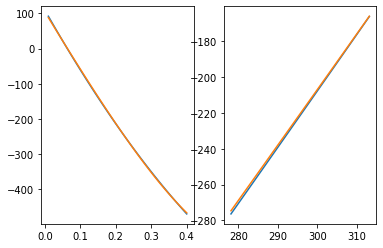

In [56]:
# validation regression
fig, axs = plt.subplots(1,2)

x_test = np.linspace(0.01, 0.4, 40)
h_test_regression = [output_eq(T = 298.15, x = xi) for xi in x_test]
h_test_physical = [get_h_with_cp_and_ref_25(T = 298.15, x = xi) for xi in x_test]
axs[0].plot(x_test, h_test_regression, x_test, h_test_physical)

T_test = np.linspace(278.15, 313.15, 20)
h_test_regression_2 = [output_eq(T = Ti, x = 0.2) for Ti in T_test]
h_test_physical_2 = [get_h_with_cp_and_ref_25(T = Ti, x = 0.2) for Ti in T_test]
axs[1].plot(T_test, h_test_regression_2, T_test, h_test_physical_2)

## Soluability

In [5]:
# temperature range: -5 to 117,2 °C, MgCl2-6H2O

param_soluability = [5.543, 1.834*(10**-2), -6.093*10**-4, 1.858*10**-5, -2.124*10**-7, 8.969*10**-10]

# a function of Temperature(°C), output is molality (mol/kg)
mgcl2_soluability = lambda t: polyval(t, param_soluability)
# attaintion: np.polynominal.polynominal.polyval is different from the numpy.polyval

## Saturation pressure

In [141]:
M_salz = 95.211
M_h2o = 18.015
def p_h2o_sat(T, model = 'Buck'):
    """
    
    Saturated Pressure of water gas in kPa
    
    input variavbles: 
       - T temperature in K
        
    """
    if model == "Buck":
        T_corr = T-273.15
        p_v = 0.61121 * exp( (18.678-T_corr/234.5) * (T_corr/(257.14 + T_corr)))
    if model == "Wagner":
        p_v = 100 * 220.64 * exp(((-7.85823) * (1 - T / 647.226) + (1.83991) * (1 - T / 647.226) ** 1.5 + (-11.7811) * (1 - T / 647.226) ** 3 + (22.6705) * (1 - T / 647.226) ** 3.5 + (-15.9393) * (1 - T / 647.226) ** 4 + (1.77516) * (1 - T / 647.226) ** 7.5) / (1 - (1 - T / 647.226)))
    return p_v

def get_x(xi):
    """
    moleanteil, aber angepasst mit vH = 3. (questionable)    
    input variavbles: 
       *\t xi Concentration in kg/kg
        
    """
    vH = 3
    return (xi / M_salz/1000 * vH) / ((xi / M_salz/1000 * vH) + ((1 - xi) / M_h2o/1000))
 
def pv_MgCl2(T, xi, if_return = 'pressure'):
    """
    
    vapor pressure of the Desiccant Solution in kPa
    
    input variavbles: 
        - T temperature in K
        - xi Concentration in kg/kg
        
    """
    Gamma = exp(get_x(xi) * ((get_x(xi) - (-1.195 + 0.002513 * (298 - T))) + (get_x(xi) * (-19.31 - 0.01843 * (298 - T)))))
    activity = Gamma * (1 - get_x(xi))
    ps_h2o = p_h2o_sat(T)
    if if_return == 'pressure':
        return activity * ps_h2o
    elif if_return == 'rH':
        return activity

## density

In [159]:
dw_coeff= [1.9937718430, 1.0985211604, -0.5094492996, -1.7619124270, -44.9005480267, -723692.2618632]
tau = lambda T: 1-T/647
rho_W = lambda T: 322 * (1+dw_coeff[0]*tau(T)**(1/3)+dw_coeff[1]*tau(T)**(2/3)+dw_coeff[2]*tau(T)**(5/3)+dw_coeff[3]*tau(T)**(16/3)+
                dw_coeff[4]*tau(T)**(43/3)+dw_coeff[5]*tau(T)**(110/3));

In [165]:
polyBrine = lambda T, xi: (0.108 + 8.68e-4*T)*xi**2 + (0.6802 + 4.928e-4*T)*xi + 1
rho_des = lambda T,xi: polyBrine(T, xi) * rho_W(T)

# Validation

## Saturation pressure

In [103]:
df_vp = pd.read_excel("../table/TCF/Validation_for_ZB.xlsx", header=[0,1,2,], index_col=0,sheet_name="vapor_pressure")

In [151]:
x_sp = np.arange(1,5,0.1) # array of molality for saturation pressure (sp)
pv_303 = [pv_MgCl2(303, molal_to_massfr(i)) for i in x_n]
pv_313 = [pv_MgCl2(313, molal_to_massfr(i)) for i in x_n]
pv_323 = [pv_MgCl2(323, molal_to_massfr(i)) for i in x_n]
pv_333 = [pv_MgCl2(333, molal_to_massfr(i)) for i in x_n]
pv_343 = [pv_MgCl2(343, molal_to_massfr(i)) for i in x_n]

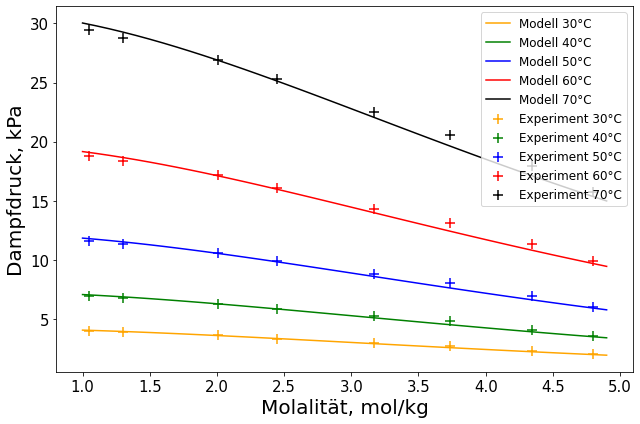

In [193]:
fig, ax = plt.subplots(figsize=(9,6))

ax.scatter(df_vp.index, df_vp["Vapor Pressure (kPa)"][303]["exp 303"], label = "Experiment 30°C", color = "orange", marker = "+", s = 120)
ax.plot(x_sp, pv_303, label = "Modell 30°C", color = "orange")

ax.scatter(df_vp.index, df_vp["Vapor Pressure (kPa)"][313]["exp 313"], label = "Experiment 40°C", color = "green", marker = "+", s = 120)
ax.plot(x_sp, pv_313, label = "Modell 40°C", color = "green")

ax.scatter(df_vp.index, df_vp["Vapor Pressure (kPa)"][323]["exp 323"], label = "Experiment 50°C", color = "blue", marker = "+", s = 120)
ax.plot(x_sp, pv_323, label = "Modell 50°C", color = "blue")

ax.scatter(df_vp.index, df_vp["Vapor Pressure (kPa)"][333]["exp 333"], label = "Experiment 60°C", color = "red", marker = "+", s = 120)
ax.plot(x_sp, pv_333, label = "Modell 60°C", color = "red")

ax.scatter(df_vp.index, df_vp["Vapor Pressure (kPa)"][343]["exp 343"], label = "Experiment 70°C", color = "black", marker = "+", s = 120)
ax.plot(x_sp, pv_343, label = "Modell 70°C", color = "black")

ax.set_xlabel("Molalität, mol/kg", size = 20)
ax.set_ylabel("Dampfdruck, kPa", size = 20)
ax.legend(fontsize = 12)
ax.tick_params(labelsize = 15)
plt.tight_layout()

plt.savefig('../plot/medium_model/validation_mgcl2_pressure.png', dpi=300, transparent=True)

## Soluability

In [10]:
df_sol = pd.read_excel("../table/TCF/Validation_for_ZB.xlsx", sheet_name="Soluability")

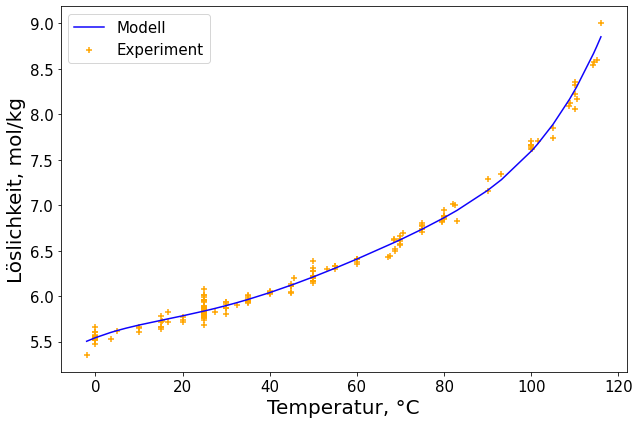

In [197]:
fig, ax = plt.subplots(figsize=(9,6))

ax.scatter(df_sol.Temperatur, df_sol.exp, label = "Experiment", color = "orange", marker = "+")
ax.plot(df_sol.Temperatur, df_sol.Temperatur.apply(mgcl2_soluability), label = "Modell", color = "#0f03fc")

ax.set_xlabel("Temperatur, °C", size = 20)
ax.set_ylabel("Löslichkeit, mol/kg", size = 20)
ax.legend(fontsize = 15)
ax.tick_params(labelsize = 15)
plt.tight_layout()
plt.savefig('../plot/medium_model/validation_mgcl2_soluability.png', dpi=300, transparent=True)

## c_p

In [23]:
# reference data of cp from literature
df_ref_cp = pd.read_excel("../table/TCF/3_cp.xlsx", sheet_name="3")

In [24]:
# plot for validation
x_solution = np.linspace(0.02, 0.36, 18)

# y_00 = [cp_prop(273.15, i) for i in x_solution]
y_10 = [cp_MgCl2_aq(283.15, i) for i in x_solution]
y_20 = [cp_MgCl2_aq(293.15, i) for i in x_solution]
y_30 = [cp_MgCl2_aq(303.15, i) for i in x_solution]
y_40 = [cp_MgCl2_aq(313.15, i) for i in x_solution]
y_50 = [cp_MgCl2_aq(323.15, i) for i in x_solution]
y_60 = [cp_MgCl2_aq(333.15, i) for i in x_solution]

# df_ref['00_sim'] = y_00
df_ref_cp['10_sim'] = y_10
df_ref_cp['20_sim'] = y_20
df_ref_cp['30_sim'] = y_30
df_ref_cp['40_sim'] = y_40
df_ref_cp['50_sim'] = y_50
df_ref_cp['60_sim'] = y_60

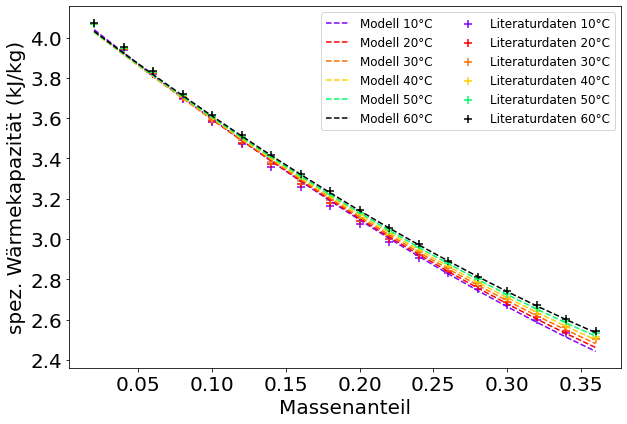

In [189]:
fig, ax = plt.subplots(figsize=(9,6))

# ax.scatter(x_solution, df_ref[0]/1000, label = "Literaturdaten@0°C", marker = "o", s = 100, color = "#0f03fc")
# ax.plot(x_solution, df_ref['00_sim'], label = "Berechnung@0°C", color = "#0f03fc", linestyle='dashed')

ax.scatter(x_solution, df_ref_cp[10]/1000, label = "Literaturdaten 10°C", marker = "+", s = 50,  color = "#7b03fc")
ax.plot(x_solution, df_ref_cp['10_sim'], label = "Modell 10°C", color = "#7b03fc", linestyle='dashed')

ax.scatter(x_solution, df_ref_cp[20]/1000, label = "Literaturdaten 20°C", marker = "+", s = 50,  color = "red")
ax.plot(x_solution, df_ref_cp['20_sim'], label = "Modell 20°C", color = "red", linestyle='dashed')

ax.scatter(x_solution, df_ref_cp[30]/1000, label = "Literaturdaten 30°C", marker = "+", s = 50,  color = "#fc6f03")
ax.plot(x_solution, df_ref_cp['30_sim'], label = "Modell 30°C", color = "#fc6f03", linestyle='dashed')

ax.scatter(x_solution, df_ref_cp[40]/1000, label = "Literaturdaten 40°C", marker = "+", s = 50,  color = "#fcce03")
ax.plot(x_solution, df_ref_cp['40_sim'], label = "Modell 40°C", color = "#fcce03", linestyle='dashed')

ax.scatter(x_solution, df_ref_cp[50]/1000, label = "Literaturdaten 50°C", marker = "+", s =50,  color = "#03fc6f")
ax.plot(x_solution, df_ref_cp['50_sim'], label = "Modell 50°C", color = "#03fc6f", linestyle='dashed')

ax.scatter(x_solution, df_ref_cp[60]/1000, label = "Literaturdaten 60°C", marker = "+", s = 50,  color = "black")
ax.plot(x_solution, df_ref_cp['60_sim'], label = "Modell 60°C", color = "black", linestyle='dashed')

ax.set_xlabel("Massenanteil", size = 20)
ax.set_ylabel("spez. Wärmekapazität (kJ/kg)", size = 20)

# ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
ax.legend(fontsize = 12, ncol = 2)
ax.tick_params(labelsize = 20)

plt.tight_layout()
plt.savefig('../plot/medium_model/validation_mgcl2_cp.png', dpi=300, transparent=True)

In [103]:
# qualitativ
df_ref_reverse = df_ref_cp.drop(columns=["molality"]).set_index("mass fraction").T

RMSRE(ref=df_ref_reverse.iloc[1:7, :][0.3]/1000, sim=df_ref_reverse.tail(6)[0.3])

0.0026989656057747704

## enthalpy h

In [35]:
df_ref_h = pd.read_excel("../table/TCF/data from merkel.xlsx", sheet_name="MgCl2")

In [57]:
# transfer columns of dataframe to list
x_60 = df_ref_h["x60"].dropna().tolist()
y_60 = df_ref_h["i60"].dropna().tolist()

y_40 = df_ref_h["i40"].dropna().tolist()
x_40 = df_ref_h["x40"].dropna().tolist()

y_20 = df_ref_h["i20"].dropna().tolist()
x_20 = df_ref_h["x20"].dropna().tolist()

x_00 = df_ref_h["x00"].dropna().tolist()
y_00 = df_ref_h["i00"].dropna().tolist()

x_25 = np.linspace(0, 0.6, num = 20, endpoint = True)#x_20
y_25 = [h_at_25_mass_frac(i)/4.184 for i in x_25]

In [58]:
# fit merkel data into polynorm (so that a function of merkel diagramm could also be generated, which compares with propsed formula)
z_60 = np.polyfit(x_60, y_60, 5, full=True)
z_40 = np.polyfit(x_40, y_40, 5, full=True)
z_20 = np.polyfit(x_20, y_20, 5, full=True)
z_00 = np.polyfit(x_00, y_00, 3, full=True)

In [59]:
# convert polynorm to callable functions
p_60 = np.poly1d(z_60[0])
p_40 = np.poly1d(z_40[0])
p_20 = np.poly1d(z_20[0])
p_00 = np.poly1d(z_00[0])

In [60]:
# generate a dict for later use
dict_integ_func = {'t20':p_20, 't40':p_40, 't60':p_60, 't0':p_00}

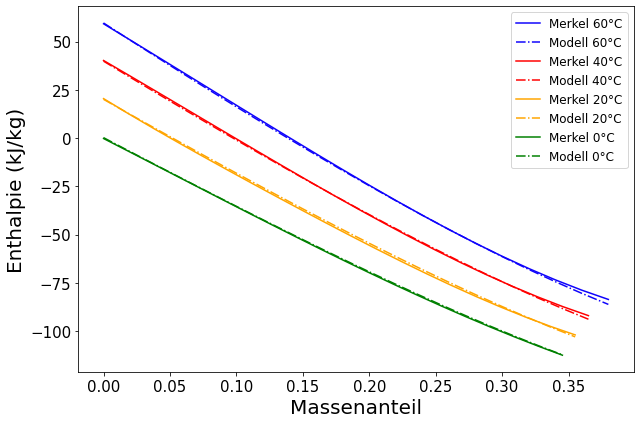

In [195]:
# plot
fig, ax = plt.subplots(figsize=(9,6))

# 60
x_60_new = np.linspace(0, 0.38, num = 20, endpoint = True)
y_60_new = p_60(x_60_new)

y_60_2 = [get_h_with_cp_and_ref_25(333.15, i)/4.184 for i in x_60_new]

# 40
x_40_new = np.linspace(0, 0.365, num = 20, endpoint = True)
y_40_new = p_40(x_40_new)

y_40_2 = [get_h_with_cp_and_ref_25(313.15, i)/4.184 for i in x_40_new]

# 20
x_20_new = np.linspace(0, 0.355, num = 20, endpoint = True)
y_20_new = p_20(x_20_new)

y_20_2 = [get_h_with_cp_and_ref_25(293.15, i)/4.184 for i in x_20_new]

# 0
x_00_new = np.linspace(0, 0.3454, num = 20, endpoint = True)
y_00_new = p_00(x_00_new)

y_00_2 = [get_h_with_cp_and_ref_25(273.15, i)/4.184 for i in x_00_new]


ax.plot(x_60_new, y_60_new, label = "Merkel 60°C", color = "#0f03fc")
ax.plot(x_60_new, y_60_2, label = "Modell 60°C", color = "#0f03fc", linestyle='-.')

ax.plot(x_40_new, y_40_new, label = "Merkel 40°C", color = "red")
ax.plot(x_40_new, y_40_2, label = "Modell 40°C", color = "red", linestyle='-.')

ax.plot(x_20_new, y_20_new, label = "Merkel 20°C", color = "orange")
ax.plot(x_20_new, y_20_2, label = "Modell 20°C", color = "orange", linestyle='-.')

ax.plot(x_00_new, y_00_new, label = "Merkel 0°C", color = "green")
ax.plot(x_00_new, y_00_2, label = "Modell 0°C", color = "green", linestyle='-.')

ax.set_xlabel("Massenanteil", size = 20)
ax.set_ylabel("Enthalpie (kJ/kg)", size = 20)
ax.tick_params(labelsize = 15)

plt.legend(fontsize = 12)
plt.tight_layout()

plt.savefig('../plot/medium_model/validation_mgcl2_h.png', dpi=300, transparent=True)

## density

In [157]:
df_dens = pd.read_excel("../table/TCF/Validation_for_ZB.xlsx", sheet_name="density")

In [166]:
df_dens

,Molality_0,d_exp_0,d_sim_0,Molality_5,d_exp_5,d_sim_5,Molality_15,d_exp_15,d_sim_15,Molality_25,d_exp_25,d_sim_25,Molality_35,d_exp_35,d_sim_35
0,0.00469,1.000231,1.00016,0.00469,1.000348,1.00028,0.00469,0.999477,0.999421,0.00469,0.997417,0.997372,0.00469,0.994394,0.994366
1,0.00469,1.000237,1.00016,0.00978,1.000780,1.00068,0.00978,0.999890,0.999819,0.00978,0.997830,0.997771,0.04851,0.997837,0.997807
2,0.00978,1.000662,1.00055,0.01972,1.001579,1.00145,0.01972,1.000693,1.000600,0.00989,0.997842,0.997780,0.09627,1.001579,1.001540
3,0.01972,1.001485,1.00132,0.04137,1.003345,1.00313,0.04137,1.002419,1.002280,0.00989,0.997847,0.997780,0.28278,1.015721,1.015940
4,0.04137,1.003263,1.00300,0.04851,1.003931,1.00368,0.04851,1.002986,1.002840,0.01972,0.998621,0.998551,0.37485,1.022590,1.022940
5,0.04851,1.003858,1.00355,0.07890,1.006352,1.00603,0.07890,1.005375,1.005200,0.04851,1.000899,1.000800,0.40811,1.025020,1.025450
6,0.07890,1.006318,1.00589,0.09627,1.007769,1.00737,0.09627,1.006765,1.006540,0.05038,1.001039,1.000950,0.55193,1.035505,1.036220
7,0.09627,1.007749,1.00722,0.19500,1.015588,1.01493,0.19525,1.014434,1.014170,0.05038,1.001044,1.000950,NaN,NaN,NaN
8,0.19500,1.015651,1.01476,0.19525,1.015588,1.01495,0.37485,1.028094,1.027790,0.07890,1.003257,1.003170,NaN,NaN,NaN
9,0.19525,1.015696,1.01478,0.25278,1.022392,1.01932,0.40811,1.030564,1.030280,0.09970,1.004890,1.004790,NaN,NaN,NaN


In [178]:
x_den = np.arange(0, 1, 0.01)
rho_0 = np.asarray([rho_des(273.15, molal_to_massfr(i)) for i in x_den])/1000
rho_5 = np.asarray([rho_des(278.15, molal_to_massfr(i)) for i in x_den])/1000
rho_15 = np.asarray([rho_des(288.15, molal_to_massfr(i)) for i in x_den])/1000
rho_25 = np.asarray([rho_des(298.15, molal_to_massfr(i)) for i in x_den])/1000
rho_35 = np.asarray([rho_des(308.15, molal_to_massfr(i)) for i in x_den])/1000

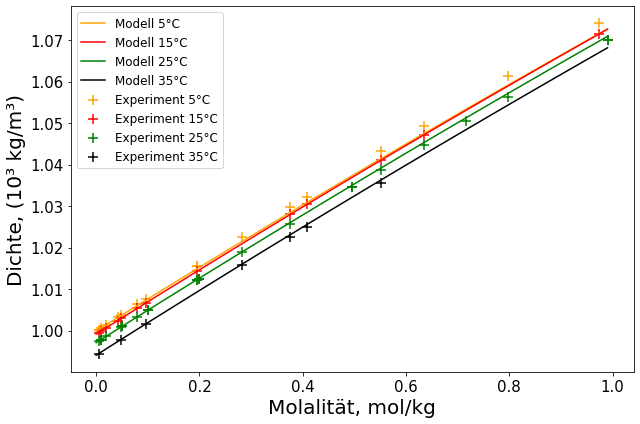

In [187]:
fig, ax = plt.subplots(figsize=(9,6))

ax.scatter(df_dens.Molality_0.dropna(), df_dens["d_exp_0"].dropna(), label = "Experiment 5°C", color = "orange", s = 120, marker = "+")
ax.plot(x_den, rho_0, label = "Modell 5°C", color = "orange", )

# ax.scatter(df_dens.Molality_5.dropna(), df_dens["d_exp_5"].dropna(), label = "Experiment 278K", color = "blue", s = 120, marker = "+")
# ax.plot(x_den, rho_5, label = "Modell 278K", color = "blue", )

ax.scatter(df_dens.Molality_15.dropna(), df_dens["d_exp_15"].dropna(), label = "Experiment 15°C", color = "red", s = 120, marker = "+")
ax.plot(x_den, rho_15, label = "Modell 15°C", color = "red", )

ax.scatter(df_dens.Molality_25.dropna(), df_dens["d_exp_25"].dropna(), label = "Experiment 25°C", color = "green", s = 120,  marker = "+")
ax.plot(x_den, rho_25, label = "Modell 25°C", color = "green", )

ax.scatter(df_dens.Molality_35.dropna(), df_dens["d_exp_35"].dropna(), label = "Experiment 35°C", color = "black", s = 120,  marker = "+")
ax.plot(x_den, rho_35, label = "Modell 35°C", color = "black", )

ax.set_xlabel("Molalität, mol/kg", size = 20, )
ax.set_ylabel("Dichte, (10³ kg/m³)", size = 20, )
ax.tick_params(labelsize = 15)
ax.legend(fontsize = 12)

plt.tight_layout()

plt.savefig('../plot/medium_model/validation_mgcl2_density.png', dpi=300, transparent=True)